<a href="https://colab.research.google.com/github/isaacmenchaca97/EfficientNetB0/blob/main/general_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Digital Image Processing for General Image Classification: Final Project
###Isaac Menchaca Panecatl
###Dr. Ulises Moya
###Computer Science Master's
**Based on paper**: [EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks](https://arxiv.org/abs/1905.11946)  (2019), by Mingxing Tan and Quoc V. Le, introduces an innovative approach to scaling convolutional neural networks (CNNs) efficiently and effectively.

**Objective**: To develop an image classification system using the pre-trained EfficientNet-B0 model, evaluating the impact of various digital image processing techniques (blur and noise) on the model's performance when classifying 100 general images from a selected dataset.

**Methodology**:


1.   Data Preparation: Select 100 images from a general-purpose dataset.
Perform dimensionality preprocessing to standardize the input size for the EfficientNet-B0 model.
2.   Baseline Classification: Use the pre-trained EfficientNet-B0 model to classify the original images and record metrics.
1.   Testing with Image Processing:
  - Blur: Apply a blur filter (Gaussian Blur) to the images and perform classification using EfficientNet-B0.
  - Noise: Add random noise (salt-and-pepper) to the images and repeat the classification.
2.   Results Analysis: Compare classification metrics across original and processed images.
Evaluate how each image processing technique influences the model's performance.
1.   Conclusions: Identify which image modifications positively or negatively affect classification accuracy.


**Link to video**:

##1. Data Preparation

In [1]:
#!/usr/bin/env python
## -*- coding: utf-8 -*-
__author__ = ["Isaac Menchaca Panecatl"]
__copyright__ = "Copyright 2024"
__credits__ = ["Isaac Menchaca Panecatl"]
__license__ = "MIT"
__version__ = "0.0.1"
__maintainer__ = ["Isaac Menchaca Panecatl"]
__email__ = "isaac.menchaca@edu.uag.mx"
__status__ = "Development"

import torch
from pycocotools.coco import COCO
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
import warnings
import os
from urllib.parse import urlparse
from torchvision.models import efficientnet_b0
import urllib.request
warnings.filterwarnings('ignore')
%matplotlib inline

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cpu for inference


In [2]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip -O coco_ann2017.zip
!unzip coco_ann2017.zip

--2024-12-06 08:36:59--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.49.252, 52.217.228.249, 16.182.71.185, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.49.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘coco_ann2017.zip’

coco_ann2017.zip    100%[===================>] 241.19M  96.3MB/s    in 2.5s    

2024-12-06 08:37:02 (96.3 MB/s) - ‘coco_ann2017.zip’ saved [252907541/252907541]

Archive:  coco_ann2017.zip
  inflating: annotations/instances_train2017.json  
  inflating: annotations/instances_val2017.json  
  inflating: annotations/captions_train2017.json  
  inflating: annotations/captions_val2017.json  
  inflating: annotations/person_keypoints_train2017.json  
  inflating: annotations/person_keypoints_val2017.json  


In [3]:
# Ruta al archivo de anotaciones (puedes descargarlo desde el sitio de COCO)
annFile = 'annotations/instances_val2017.json'

# Cargar el archivo de anotaciones
coco = COCO(annFile)

# Obtener los IDs de las imágenes
img_ids = coco.getImgIds()

# Generar una lista con las URLs de las imágenes
base_url = 'http://images.cocodataset.org/val2017/'  # Cambia según el conjunto de datos

uris = []
uris_name = []

# Obtener las URLs para las primeras 100 imágenes
for img_id in img_ids[:100]:
    img_info = coco.loadImgs(img_id)[0]
    img_url = base_url + img_info['file_name']
    uris.append(img_url)
    uris_name.append(img_info['file_name'])

# Ver las primeras 10 URLs generadas
for uri in uris[:10]:
    print(uri)

loading annotations into memory...
Done (t=1.32s)
creating index...
index created!
http://images.cocodataset.org/val2017/000000397133.jpg
http://images.cocodataset.org/val2017/000000037777.jpg
http://images.cocodataset.org/val2017/000000252219.jpg
http://images.cocodataset.org/val2017/000000087038.jpg
http://images.cocodataset.org/val2017/000000174482.jpg
http://images.cocodataset.org/val2017/000000403385.jpg
http://images.cocodataset.org/val2017/000000006818.jpg
http://images.cocodataset.org/val2017/000000480985.jpg
http://images.cocodataset.org/val2017/000000458054.jpg
http://images.cocodataset.org/val2017/000000331352.jpg


In [4]:
# Función para descargar y guardar la imagen
def download_image(url, save_folder):
    # Hacer la solicitud HTTP para obtener la imagen
    response = requests.get(url)

    # Verificar que la solicitud fue exitosa
    if response.status_code == 200:
        # Obtener el nombre de la imagen a partir de la URL
        image_name = os.path.basename(urlparse(url).path)

        # Crear la ruta completa para guardar la imagen
        save_path = os.path.join(save_folder, image_name)

        # Guardar la imagen en el directorio especificado
        with open(save_path, 'wb') as f:
            f.write(response.content)
        print(f"Imagen guardada en: {save_path}")
    else:
        print(f"Error al descargar la imagen: {url}")

# Carpeta donde se guardarán las imágenes
save_folder = 'downloaded_images'

# Crear la carpeta si no existe
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

# Descargar y guardar cada imagen
for url in uris:
    download_image(url, save_folder)

Imagen guardada en: downloaded_images/000000397133.jpg
Imagen guardada en: downloaded_images/000000037777.jpg
Imagen guardada en: downloaded_images/000000252219.jpg
Imagen guardada en: downloaded_images/000000087038.jpg
Imagen guardada en: downloaded_images/000000174482.jpg
Imagen guardada en: downloaded_images/000000403385.jpg
Imagen guardada en: downloaded_images/000000006818.jpg
Imagen guardada en: downloaded_images/000000480985.jpg
Imagen guardada en: downloaded_images/000000458054.jpg
Imagen guardada en: downloaded_images/000000331352.jpg
Imagen guardada en: downloaded_images/000000296649.jpg
Imagen guardada en: downloaded_images/000000386912.jpg
Imagen guardada en: downloaded_images/000000502136.jpg
Imagen guardada en: downloaded_images/000000491497.jpg
Imagen guardada en: downloaded_images/000000184791.jpg
Imagen guardada en: downloaded_images/000000348881.jpg
Imagen guardada en: downloaded_images/000000289393.jpg
Imagen guardada en: downloaded_images/000000522713.jpg
Imagen gua

##2. Baseline Classification

In [5]:
# Cargar el modelo preentrenado
model = efficientnet_b0(pretrained=True)

# Cambiar a modo de evaluación (inferencia)
model.eval()

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 79.8MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [6]:
# Transformaciones necesarias
preprocess = transforms.Compose([
    transforms.Resize(256),                # Escalar el lado más pequeño a 256 píxeles
    transforms.CenterCrop(224),            # Recortar el centro a 224x224
    transforms.ToTensor(),                 # Convertir a tensor
    transforms.Normalize(                  # Normalizar con medias y desviaciones estándar de ImageNet
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [7]:
url = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
response = urllib.request.urlopen(url)
labels = json.load(response)

predictions = []

for name in uris_name:
    # Cargar una imagen
    image = Image.open("downloaded_images/" + name).convert("RGB")
    input_tensor = preprocess(image).unsqueeze(0)  # Añadir dimensión batch

    # Desactivar gradientes para inferencia más rápida
    with torch.no_grad():
        output = model(input_tensor)

    # Convertir salidas a probabilidades con softmax
    probabilities = torch.nn.functional.softmax(output[0], dim=0)

    # Mostrar la clase más probable
    top1_idx = probabilities.argmax().item()
    print(f"Predicción: {labels[top1_idx]} (Confianza: {probabilities[top1_idx]*100:.2f}%)")

    predictions.append(float(probabilities[top1_idx]*100))

Predicción: restaurant (Confianza: 57.56%)
Predicción: microwave oven (Confianza: 87.48%)
Predicción: shopping cart (Confianza: 11.62%)
Predicción: unicycle (Confianza: 99.36%)
Predicción: moped (Confianza: 37.55%)
Predicción: toilet seat (Confianza: 31.58%)
Predicción: toilet seat (Confianza: 33.82%)
Predicción: scooter (Confianza: 30.81%)
Predicción: tub (Confianza: 24.50%)
Predicción: toilet seat (Confianza: 74.44%)
Predicción: scooter (Confianza: 32.42%)
Predicción: laptop computer (Confianza: 19.17%)
Predicción: prison (Confianza: 36.36%)
Predicción: television (Confianza: 44.23%)
Predicción: tray (Confianza: 19.99%)
Predicción: wing (Confianza: 22.73%)
Predicción: ox (Confianza: 19.89%)
Predicción: park bench (Confianza: 75.15%)
Predicción: water buffalo (Confianza: 52.53%)
Predicción: taxicab (Confianza: 27.64%)
Predicción: moving van (Confianza: 42.32%)
Predicción: taxicab (Confianza: 54.98%)
Predicción: minibus (Confianza: 44.06%)
Predicción: trolleybus (Confianza: 49.04%)
Pre

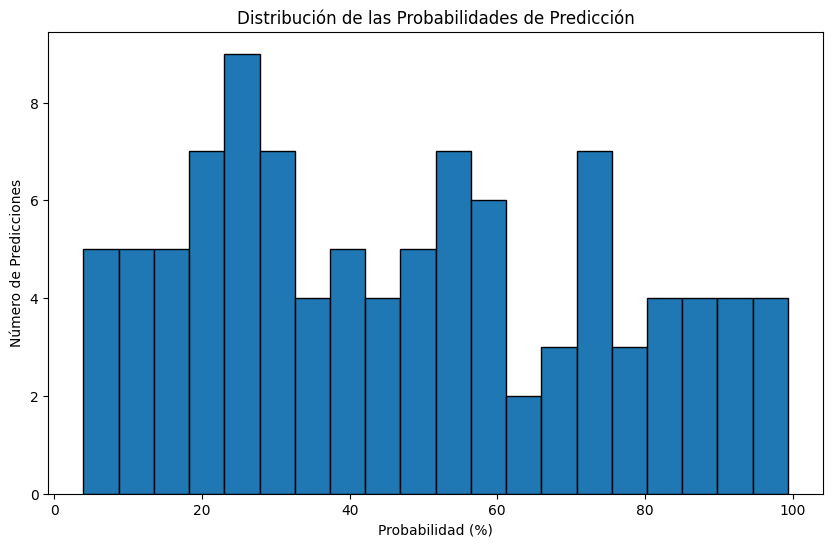

In [8]:
# Graficar el histograma de las probabilidades
plt.figure(figsize=(10, 6))
plt.hist(predictions, bins=20, edgecolor='black')
plt.title("Distribución de las Probabilidades de Predicción")
plt.xlabel("Probabilidad (%)")
plt.ylabel("Número de Predicciones")
plt.show()


##3. Testing with Image Processing

###Blur

In [9]:
import os
from PIL import Image, ImageFilter

# Función para aplicar blur a una imagen y guardarla
def apply_blur_and_save(image_path, output_folder):
    try:
        # Abrir la imagen
        img = Image.open(image_path)

        # Aplicar efecto blur
        img_blurred = img.filter(ImageFilter.GaussianBlur(radius=5))  # Cambiar el radio para ajustar el desenfoque

        # Crear la ruta para guardar la imagen con blur
        image_name = os.path.basename(image_path)
        save_path = os.path.join(output_folder, image_name)

        # Guardar la imagen con el efecto blur
        img_blurred.save(save_path)
        print(f"Imagen con blur guardada en: {save_path}")
    except Exception as e:
        print(f"Error al procesar la imagen {image_path}: {e}")

# Carpeta de imágenes descargadas
input_folder = 'downloaded_images'

# Carpeta para guardar imágenes con blur
output_folder = 'blurred_images'

# Crear la carpeta de salida si no existe
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Aplicar efecto blur a cada imagen de la carpeta descargada
for image_file in os.listdir(input_folder):
    image_path = os.path.join(input_folder, image_file)
    apply_blur_and_save(image_path, output_folder)


Imagen con blur guardada en: blurred_images/000000226111.jpg
Imagen con blur guardada en: blurred_images/000000174482.jpg
Imagen con blur guardada en: blurred_images/000000460347.jpg
Imagen con blur guardada en: blurred_images/000000480985.jpg
Imagen con blur guardada en: blurred_images/000000296649.jpg
Imagen con blur guardada en: blurred_images/000000266409.jpg
Imagen con blur guardada en: blurred_images/000000238866.jpg
Imagen con blur guardada en: blurred_images/000000565778.jpg
Imagen con blur guardada en: blurred_images/000000448365.jpg
Imagen con blur guardada en: blurred_images/000000025560.jpg
Imagen con blur guardada en: blurred_images/000000087038.jpg
Imagen con blur guardada en: blurred_images/000000066523.jpg
Imagen con blur guardada en: blurred_images/000000555705.jpg
Imagen con blur guardada en: blurred_images/000000181666.jpg
Imagen con blur guardada en: blurred_images/000000475779.jpg
Imagen con blur guardada en: blurred_images/000000312421.jpg
Imagen con blur guardada

In [10]:
predictions_blur = []

for name in uris_name:
    # Cargar una imagen
    image = Image.open("blurred_images/" + name).convert("RGB")
    input_tensor = preprocess(image).unsqueeze(0)  # Añadir dimensión batch

    # Desactivar gradientes para inferencia más rápida
    with torch.no_grad():
        output = model(input_tensor)

    # Convertir salidas a probabilidades con softmax
    probabilities = torch.nn.functional.softmax(output[0], dim=0)

    # Mostrar la clase más probable
    top1_idx = probabilities.argmax().item()
    print(f"Predicción: {labels[top1_idx]} (Confianza: {probabilities[top1_idx]*100:.2f}%)")

    predictions_blur.append(float(probabilities[top1_idx]*100))

Predicción: balance beam (Confianza: 13.40%)
Predicción: pill bottle (Confianza: 63.57%)
Predicción: moving van (Confianza: 14.19%)
Predicción: pulled rickshaw (Confianza: 9.95%)
Predicción: moped (Confianza: 26.87%)
Predicción: switch (Confianza: 15.95%)
Predicción: beaker (Confianza: 8.71%)
Predicción: toy store (Confianza: 8.04%)
Predicción: ring binder (Confianza: 23.12%)
Predicción: toilet seat (Confianza: 51.34%)
Predicción: pulled rickshaw (Confianza: 4.09%)
Predicción: library (Confianza: 21.68%)
Predicción: sawmill (Confianza: 2.00%)
Predicción: four-poster bed (Confianza: 18.23%)
Predicción: tray (Confianza: 12.67%)
Predicción: beaker (Confianza: 13.02%)
Predicción: Sussex Spaniel (Confianza: 6.80%)
Predicción: golf ball (Confianza: 17.43%)
Predicción: dromedary (Confianza: 4.43%)
Predicción: semi-trailer truck (Confianza: 8.18%)
Predicción: moving van (Confianza: 71.98%)
Predicción: school bus (Confianza: 11.98%)
Predicción: mobile home (Confianza: 29.41%)
Predicción: monast

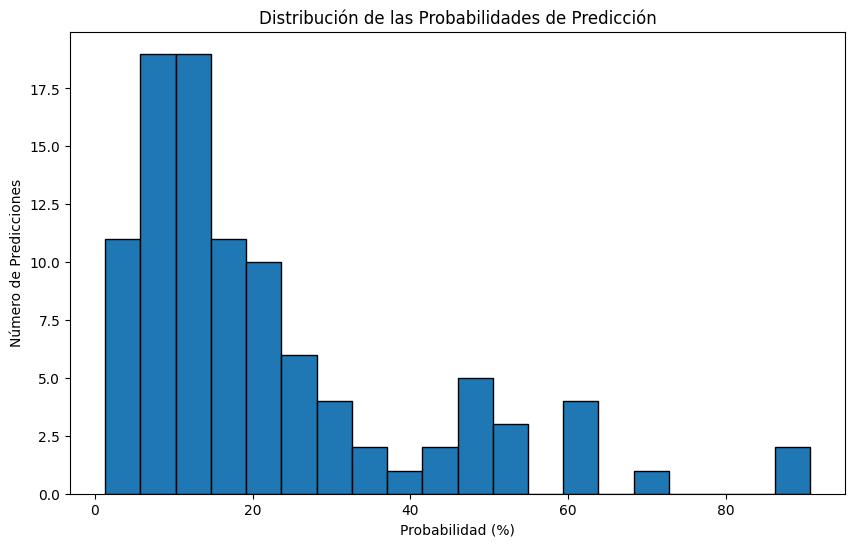

In [11]:
# Graficar el histograma de las probabilidades
plt.figure(figsize=(10, 6))
plt.hist(predictions_blur, bins=20, edgecolor='black')
plt.title("Distribución de las Probabilidades de Predicción")
plt.xlabel("Probabilidad (%)")
plt.ylabel("Número de Predicciones")
plt.show()

###Noise

In [12]:
import os
import numpy as np
from PIL import Image

# Función para aplicar ruido sal y pimienta a una imagen y guardarla
def apply_salt_and_pepper_noise(image_path, output_folder, amount=0.02, salt_vs_pepper=0.5):
    try:
        # Abrir la imagen
        img = Image.open(image_path).convert('RGB')  # Convertir a RGB si no lo está
        img_array = np.array(img)

        # Crear máscara para ruido
        num_pixels = img_array.size
        num_salt = int(amount * num_pixels * salt_vs_pepper)
        num_pepper = int(amount * num_pixels * (1.0 - salt_vs_pepper))

        # Agregar ruido tipo "sal" (blanco)
        coords = [np.random.randint(0, i - 1, num_salt) for i in img_array.shape]
        img_array[coords[0], coords[1], :] = 255

        # Agregar ruido tipo "pimienta" (negro)
        coords = [np.random.randint(0, i - 1, num_pepper) for i in img_array.shape]
        img_array[coords[0], coords[1], :] = 0

        # Convertir el array a imagen
        noisy_img = Image.fromarray(img_array)

        # Crear la ruta para guardar la imagen con ruido
        image_name = os.path.basename(image_path)
        save_path = os.path.join(output_folder, image_name)

        # Guardar la imagen con el ruido aplicado
        noisy_img.save(save_path)
        print(f"Imagen con ruido guardada en: {save_path}")
    except Exception as e:
        print(f"Error al procesar la imagen {image_path}: {e}")

# Carpeta de imágenes descargadas
input_folder = 'downloaded_images'

# Carpeta para guardar imágenes con ruido
output_folder = 'noisy_images'

# Crear la carpeta de salida si no existe
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Aplicar ruido sal y pimienta a cada imagen de la carpeta descargada
for image_file in os.listdir(input_folder):
    image_path = os.path.join(input_folder, image_file)
    apply_salt_and_pepper_noise(image_path, output_folder)

Imagen con ruido guardada en: noisy_images/000000226111.jpg
Imagen con ruido guardada en: noisy_images/000000174482.jpg
Imagen con ruido guardada en: noisy_images/000000460347.jpg
Imagen con ruido guardada en: noisy_images/000000480985.jpg
Imagen con ruido guardada en: noisy_images/000000296649.jpg
Imagen con ruido guardada en: noisy_images/000000266409.jpg
Imagen con ruido guardada en: noisy_images/000000238866.jpg
Imagen con ruido guardada en: noisy_images/000000565778.jpg
Imagen con ruido guardada en: noisy_images/000000448365.jpg
Imagen con ruido guardada en: noisy_images/000000025560.jpg
Imagen con ruido guardada en: noisy_images/000000087038.jpg
Imagen con ruido guardada en: noisy_images/000000066523.jpg
Imagen con ruido guardada en: noisy_images/000000555705.jpg
Imagen con ruido guardada en: noisy_images/000000181666.jpg
Imagen con ruido guardada en: noisy_images/000000475779.jpg
Imagen con ruido guardada en: noisy_images/000000312421.jpg
Imagen con ruido guardada en: noisy_imag

In [13]:
predictions_noise = []

for name in uris_name:
    # Cargar una imagen
    image = Image.open("noisy_images/" + name).convert("RGB")
    input_tensor = preprocess(image).unsqueeze(0)  # Añadir dimensión batch

    # Desactivar gradientes para inferencia más rápida
    with torch.no_grad():
        output = model(input_tensor)

    # Convertir salidas a probabilidades con softmax
    probabilities = torch.nn.functional.softmax(output[0], dim=0)

    # Mostrar la clase más probable
    top1_idx = probabilities.argmax().item()
    print(f"Predicción: {labels[top1_idx]} (Confianza: {probabilities[top1_idx]*100:.2f}%)")

    predictions_noise.append(float(probabilities[top1_idx]*100))

Predicción: sawmill (Confianza: 28.32%)
Predicción: microwave oven (Confianza: 23.04%)
Predicción: crutch (Confianza: 7.28%)
Predicción: unicycle (Confianza: 46.70%)
Predicción: mountain bike (Confianza: 61.01%)
Predicción: sink (Confianza: 23.22%)
Predicción: sink (Confianza: 24.06%)
Predicción: snowmobile (Confianza: 12.41%)
Predicción: fountain (Confianza: 8.95%)
Predicción: hamper (Confianza: 11.46%)
Predicción: prison (Confianza: 11.31%)
Predicción: jigsaw puzzle (Confianza: 53.38%)
Predicción: prison (Confianza: 46.96%)
Predicción: library (Confianza: 29.56%)
Predicción: tray (Confianza: 27.81%)
Predicción: baluster (Confianza: 8.67%)
Predicción: llama (Confianza: 38.21%)
Predicción: park bench (Confianza: 87.89%)
Predicción: dog sled (Confianza: 27.66%)
Predicción: garbage truck (Confianza: 23.94%)
Predicción: moving van (Confianza: 21.64%)
Predicción: taxicab (Confianza: 29.59%)
Predicción: minibus (Confianza: 26.09%)
Predicción: garbage truck (Confianza: 19.61%)
Predicción: sn

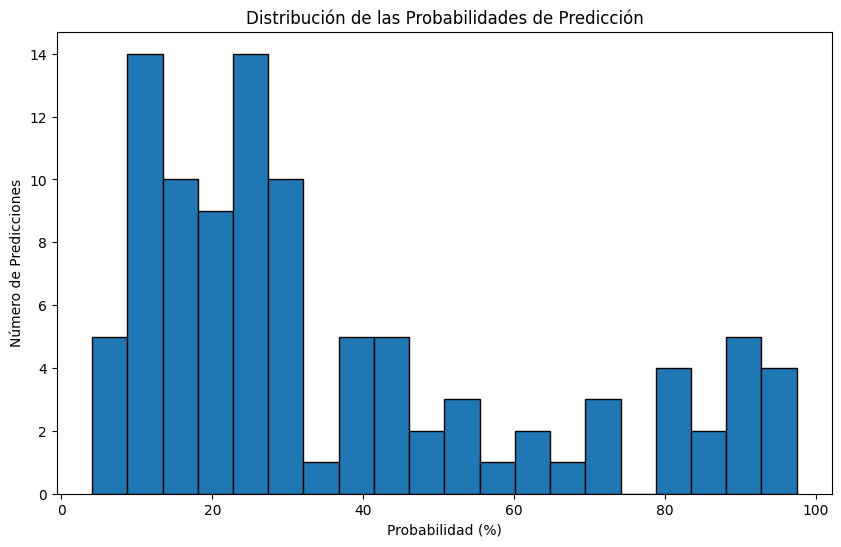

In [14]:
# Graficar el histograma de las probabilidades
plt.figure(figsize=(10, 6))
plt.hist(predictions_noise, bins=20, edgecolor='black')
plt.title("Distribución de las Probabilidades de Predicción")
plt.xlabel("Probabilidad (%)")
plt.ylabel("Número de Predicciones")
plt.show()

##4. Results Analysis

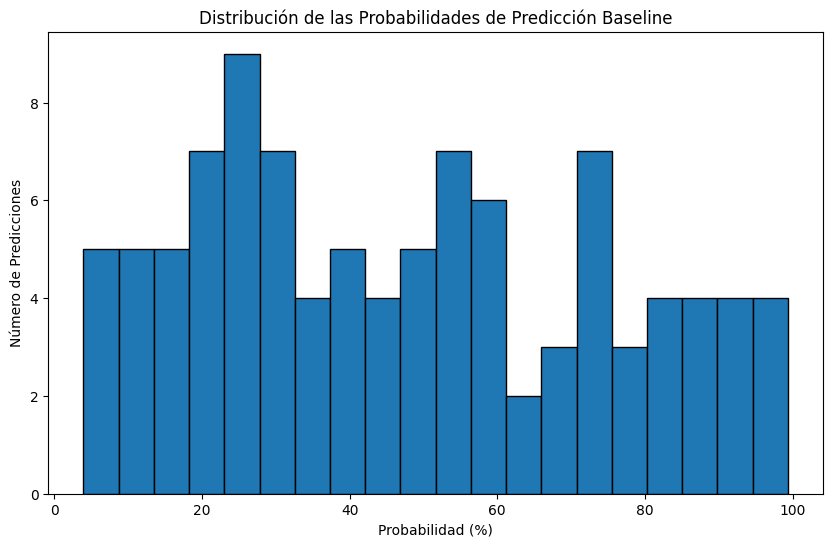

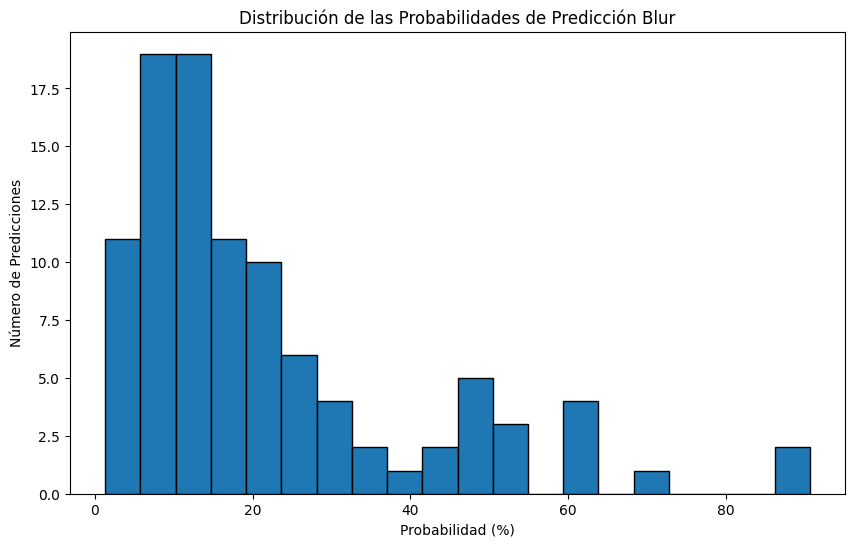

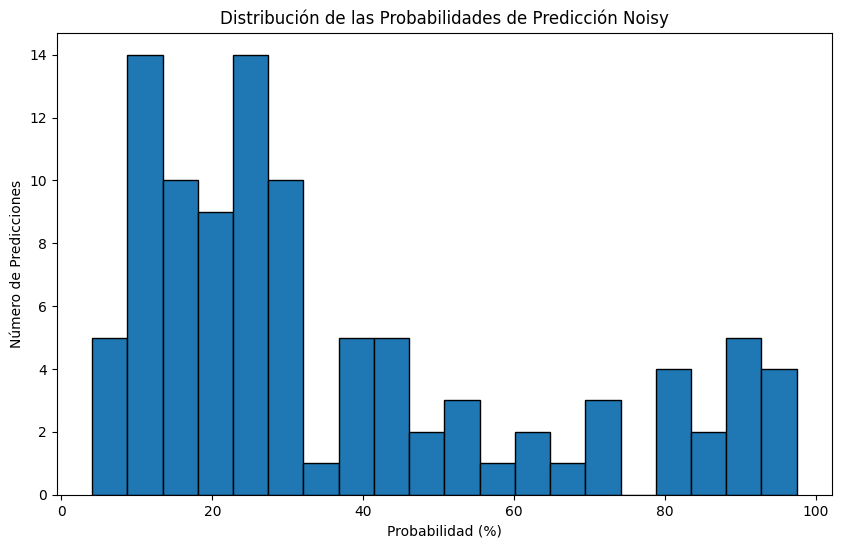

In [15]:
# Graficar el histograma de las probabilidades
plt.figure(figsize=(10, 6))
plt.hist(predictions, bins=20, edgecolor='black')
plt.title("Distribución de las Probabilidades de Predicción Baseline")
plt.xlabel("Probabilidad (%)")
plt.ylabel("Número de Predicciones")
plt.show()
# Graficar el histograma de las probabilidades
plt.figure(figsize=(10, 6))
plt.hist(predictions_blur, bins=20, edgecolor='black')
plt.title("Distribución de las Probabilidades de Predicción Blur")
plt.xlabel("Probabilidad (%)")
plt.ylabel("Número de Predicciones")
plt.show()
# Graficar el histograma de las probabilidades
plt.figure(figsize=(10, 6))
plt.hist(predictions_noise, bins=20, edgecolor='black')
plt.title("Distribución de las Probabilidades de Predicción Noisy")
plt.xlabel("Probabilidad (%)")
plt.ylabel("Número de Predicciones")
plt.show()